I recently did play the playlist DJ for private party. Previously this did involve endless comparisons of songs. Which songs go first, how to build up what does not fit. As the playlist is static songs need to match the time of the day. Before that was quite a lot of work.

But now we have AI. Everything is soo easy.

That is how i started with (Deej-AI)[https://github.com/teticio/Deej-AI].

My idea: i tell the DJ what music I like and he makes the playlist. The creator of Deej-AI explains how it is done in the repo, so thought i would have my playlist in no time.

### Playlist creation with Deej-AI
I selected a few hundered songs I like, in the hope that the software could fill the Gaps.

Running the software quickly produced playlists. They were ok, but not perfect. As I did not want repititions, the list got worse towards the end as the algorihm ran out of matches.
Something which probably could be helped with by doing a global optimization. Respecting the time of the day is completly impossible for the tool. For this we would need a better global layout editor. While there is the functionality to fill in gaps, you always need to describe what is missing. In the end it was still quite some effort.

### Why did the computer pick song A over song B.
Despite the lack of features i was sometimes pleasantly suprised by the picks and sometimes just suprised. In this notebook I want to explore why the computer picked a certain song.

We will examine our data at three different scales

- macro with tsne: there should be groups of songs due to different features
- micro with integrated gradient
- meso with grad cam


## T-SNE
I had to help the tool to create good playlists so I divided the day in a calm and a more danceable part. We will store this information for now and use it later.

### Theme metadata
We start our analyis by creating a a combined list of the split up. We note which is which as we need this later

In [10]:
import os
import csv
from pathlib import Path

AUDIO_ROOT = "/app/data/raw-previews/separate"
MANIFEST_FILE = "/app/data/raw-previews/explainabletrack_manifest.csv"

with open(MANIFEST_FILE, "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "theme"])

    for theme_dir in Path(AUDIO_ROOT).iterdir():
        if theme_dir.is_dir():
            theme = theme_dir.name
            for audio_file in theme_dir.glob("*.mp3"):
                writer.writerow([audio_file.name, theme])



### The encoded data
Before this notebook I run the encoder to my collection.
Before we continue to analyse, let's first look at what kind of data we have.

#### Spectograms
We are going to analyse sound signals. Sound is usually analysed with the help of a spectogram.
This allows us to classification analysis with a simple `Resnet`.
In the following is such a spectogram.



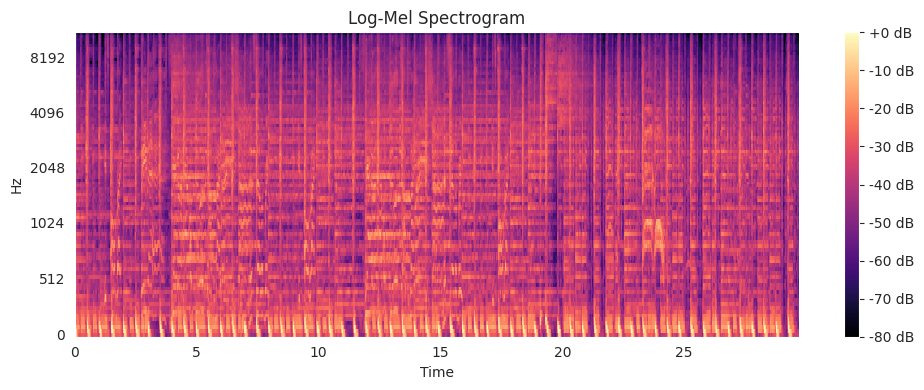

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio
filename = '/app/data/raw-previews/combined/Celebration - Single Version - Kool & The Gang.mp3'  # or .wav
y, sr = librosa.load(filename, sr=22050)

# Create log-Mel spectrogram
n_fft = 2048
hop_length = 512
n_mels = 96

S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                   hop_length=hop_length, n_mels=n_mels)
log_S = librosa.power_to_db(S, ref=np.max)

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()


### Slicing images
The act of seeing which images go together is a sort of classification. Classifying a song a whole is often not very helpful, or requires a much more complex model architecture. Instead we usually cut the model in slices and feed these slices to a model. In the following we see what such slices look like.



In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load audio
y, sr = librosa.load(filename, sr=22050)

# Parameters (match model)
n_fft = 2048
hop_length = 512
n_mels = 96
slice_size = 216  # frames per slice

# Create log-Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                   hop_length=hop_length, n_mels=n_mels)
log_S = librosa.power_to_db(S, ref=np.max)

# Normalize to [0,1]
log_S = (log_S - np.min(log_S)) / (np.max(log_S) - np.min(log_S))

# Slice
num_slices = log_S.shape[1] // slice_size
slices = np.stack([
    log_S[:, i * slice_size : (i + 1) * slice_size]
    for i in range(num_slices)
], axis=0)  # shape: [num_slices, 128, 216]


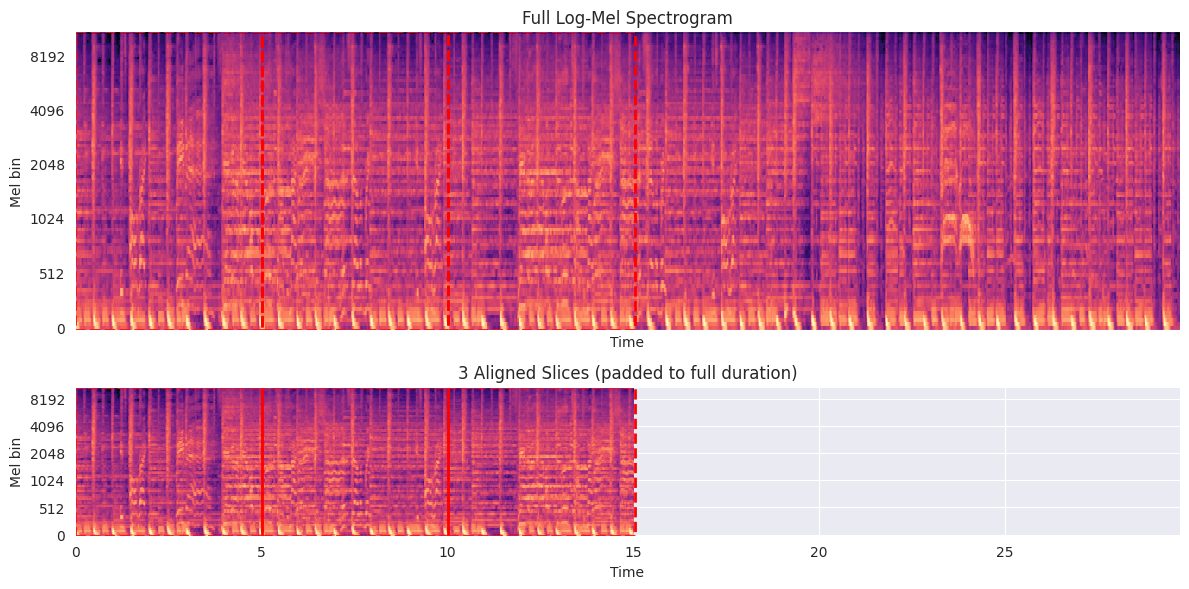

In [9]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio
filename = '/app/data/raw-previews/combined/Celebration - Single Version - Kool & The Gang.mp3'
y, sr = librosa.load(filename, sr=22050)

# Parameters
n_fft = 2048
hop_length = 512
n_mels = 96
slice_size = 216
stride = 216

# Compute log-Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                   hop_length=hop_length, n_mels=n_mels)
log_S = librosa.power_to_db(S, ref=np.max)
log_S = (log_S - np.min(log_S)) / (np.max(log_S) - np.min(log_S))

# Slice with time tracking
slices = []
starts_sec = []
for start in range(0, log_S.shape[1] - slice_size + 1, stride):
    end = start + slice_size
    slices.append(log_S[:, start:end])
    start_sec = start * hop_length / sr
    end_sec = end * hop_length / sr
    starts_sec.append((start_sec, end_sec))

# Plot
num_slices_to_show = 3
fig, axs = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# Full spectrogram
librosa.display.specshow(log_S, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='mel', ax=axs[0])
axs[0].set_title("Full Log-Mel Spectrogram")
axs[0].set_ylabel("Mel bin")

for i in range(min(num_slices_to_show, len(slices))):
    start, end = starts_sec[i]
    axs[0].axvspan(start, end, edgecolor='red', facecolor='none', lw=2, linestyle='--')


# Slices stitched together horizontally, padded to full time width
slice_canvas = np.zeros_like(log_S) * np.nan  # fill with NaNs

for i in range(min(num_slices_to_show, len(slices))):
    start_frame = int(starts_sec[i][0] * sr / hop_length)
    slice_data = slices[i]
    slice_canvas[:, start_frame:start_frame + slice_data.shape[1]] = slice_data

librosa.display.specshow(slice_canvas, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='mel', ax=axs[1])

for i in range(min(num_slices_to_show, len(slices))):
    start, end = starts_sec[i]
    axs[1].axvspan(start, end, edgecolor='red', facecolor='none', lw=2, linestyle='--')


axs[1].set_title(f"{num_slices_to_show} Aligned Slices (padded to full duration)")
axs[1].set_ylabel("Mel bin")

plt.tight_layout()
plt.show()



#### Embeddings
But instead of knowing which images go together we are interested in the quantitive difference of one song to the next. The complete Training Inference Pipeline can be visualized like this.

```{mermaid}
```{include} diagram.mmd
```

The spotify playlists used in the Training act as `Labels`. Only these Labels are Embeddings. The second network is then a standard classification in the sense that we it produces inferred labels for new files. In a final step we compare which file is closest to our query.

To answer our questions "Why was song A chosen?" we only need to analyse the inference related to training #2.

We already had a look at hour $X_{inf}$. Now let's look at the infered labels.



### tsne for high dimensionality data.
The data is of the form 100D for each file. To compare in a scatter plot we only have 2D. Therefore we need to reduce the dimensions.
T-distributed stochastic neighbor embedding (TNSE) is such a dimensionality reduction technique, [see wikipedia](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). High dimensional data can be plotted in 2D. But as with any complex method there are some caveats. A nice article about the limitations is in [distill.pub](https://distill.pub/2016/misread-tsne/).

#### TL;DR;
**t-SNE Limitations**:

- Distances are not reliable: Global structure is often distorted; distances between clusters are meaningless.
- Cluster sizes are misleading: Size/shape doesn't reflect actual data density or variance.
- Clusters can be artifacts: t-SNE can create apparent groupings even from random data.

- Sensitive to hyperparameters: Perplexity, learning rate, and iterations drastically affect results.

- Non-deterministic: Results vary with different random seeds; always run multiple times.

-  No generalization: Can't project new data without retraining (non-parametric).

- Slow on large datasets: Scales poorly; approximations or UMAP may be better.

**Best Practices**:

- Tune parameters carefully.

- Run multiple times to check stability.

- Don’t trust distances, cluster sizes, or shapes.

- Use it for exploration, not clustering or quantification.

- Compare with PCA, UMAP, or other embeddings.

So the main issues are the sensitiivy to the hyperparamers. I found few good estimates. A recent paper, [Gove et al. 2022](https://www.sciencedirect.com/science/article/pii/S2468502X22000201), came up with a comprehensive study.
In contrast to previous studies [Kobak and Berens, 2019](https://www.sciencedirect.com/science/article/pii/S2468502X22000201#b19), there found no dependence on the size of the dataset (previously 1% of dataset size). Here is a summary:

Begin: perplexity = 16, learning_rate = 10, exaggeration = 1, 1 000–2 000 iters. Above 1000 iters low variation

Tune by visual inspection

    Blobs? → raise exaggeration to 3–4.
    Lost global shape? → double learning-rate or bump perplexity (never past 16).
    Over-compressed? → lower exaggeration or learning-rate.

Still unhappy? Grid-search only inside (perplexity 2-16, lr 10-640, exaggeration 1-8) – ~50 runs max.

Big data (≫20 k points): try perplexity ≈ n/100 and lr ≈ n/12, but clamp both to the above limits.


1% would be 2.5 so we ignore this

Then iteratively follow the new recipe


In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:

# Load manifest
MANIFEST_FILE = "/app/data/raw-previews/explainabletrack_manifest.csv"
manifest = pd.read_csv(MANIFEST_FILE)

filenames = ['/opt/project/data/raw-previews/combined/' + f for f in manifest['filename']]

with open("/app/data/pickles/combined/mp3tovecs/mp3tovec.p", "rb") as f:
    mp3tovecs = pickle.load(f)


vectors = np.vstack([mp3tovecs[f] for f in filenames if f in mp3tovecs])


In [34]:
from sklearn.manifold import TSNE

from sklearn.manifold import TSNE
import numpy as np
def tsne_until_converged(
    X,
    step_iter=250,          # ≥ 250 so we do early-exag only once
    max_iter=10000,
    tol=1e-3,
    random_state=42,
    verbose=True,
    perplexity=5,
    learning_rate=10,
    exaggeration=1
):
    """
    Run t-SNE until the mean point movement < tol.
    Uses the empirical defaults (perplexity 16, lr 10, exaggeration 1);
    bumps lr / perplexity for very large data sets but clamps to safe bounds.
    Returns (embedding, [inter-step deltas], total_iter_run).
    """
    n = X.shape[0]


    common = dict(
        n_components=2,
        perplexity=perplexity,
        learning_rate=learning_rate,
        early_exaggeration=exaggeration,     # needs scikit-learn ≥ 1.4
        init="pca",
        random_state=random_state,
        verbose=False,
    )

    # --- 2. first run: include early-exaggeration phase (250 iters) --------
    total_iter = 250
    tsne = TSNE(max_iter=total_iter, **common)
    Y = tsne.fit_transform(X)

    history = []
    prev = Y.copy()

    # --- 3. continue optimisation in chunks, re-using previous Y ----------
    while total_iter < max_iter:
        total_iter += step_iter
        tsne = TSNE(
            max_iter=total_iter,
            **common,
        )
        Y = tsne.fit_transform(X)

        delta = np.linalg.norm(Y - prev, axis=1).mean()
        history.append(delta)
        if verbose:
            print(f"[{total_iter + step_iter} iters] mean move = {delta:.6f}")

        if delta < tol:
            if verbose:
                print("✓ Converged")
            break

        prev = Y.copy()


    return Y, history, total_iter


In [28]:

X = np.vstack(vectors)

In [35]:
%%capture
embedding1, movement1,max_iter1 = tsne_until_converged(X)

In [36]:
%%capture
embedding2, movement2, max_iter2 = tsne_until_converged(X, perplexity=10)

In [37]:
%%capture
embedding3, movement3, max_iter3 = tsne_until_converged(X, perplexity=16)

In [43]:
%%capture
embedding4, movement4, max_iter4 = tsne_until_converged(X, perplexity=16, exaggeration=4)

In [64]:
%%capture
embedding5, movement5, max_iter5 = tsne_until_converged(X, perplexity=16, exaggeration=4, learning_rate=40)

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_tsne_results(
    results,
    filenames=None,
    titles=None,
    palette="Set2",
    figsize=(6, 12),
):
    """
    Plot multiple t-SNE embeddings and their movement curves.

    Parameters:
        results: list of (embedding, movement) tuples
            embedding: np.ndarray of shape (n_samples, 2)
            movement: list or array of mean movement per iteration step
        filenames: list of labels or categories (shared across embeddings)
        titles: list of subplot titles (optional)
        palette: seaborn palette name or dict
        figsize: tuple for figure size
    """
    n = len(results)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(figsize[0] * n, figsize[1] * 2))

    for i, (embedding, movement) in enumerate(results):
        # 1. Plot embedding
        tsne_df = pd.DataFrame({
            "x": embedding[:, 0],
            "y": embedding[:, 1],
            "label": filenames if filenames is not None else [""] * len(embedding)
        })

        ax1 = axes[i, 0] if n > 1 else axes[0]
        sns.scatterplot(
            data=tsne_df,
            x="x", y="y",
            hue="label",
            palette=palette,
            s=60, edgecolor='k', alpha=0.7,
            ax=ax1,
            legend=False if i > 0 else "auto"
        )
        ax1.set_title(titles[i] if titles else f"t-SNE Embedding {i+1}")
        ax1.set_xlabel("TSNE-1")
        ax1.set_ylabel("TSNE-2")

        # 2. Plot movement curve
        ax2 = axes[i, 1] if n > 1 else axes[1]
        ax2.plot(movement, marker='o', linewidth=1.5)
        ax2.set_title("Mean Movement per Step")
        ax2.set_xlabel("Step")
        ax2.set_ylabel("Mean Δ Position")
        ax2.grid(True)

    plt.tight_layout()
    plt.show()


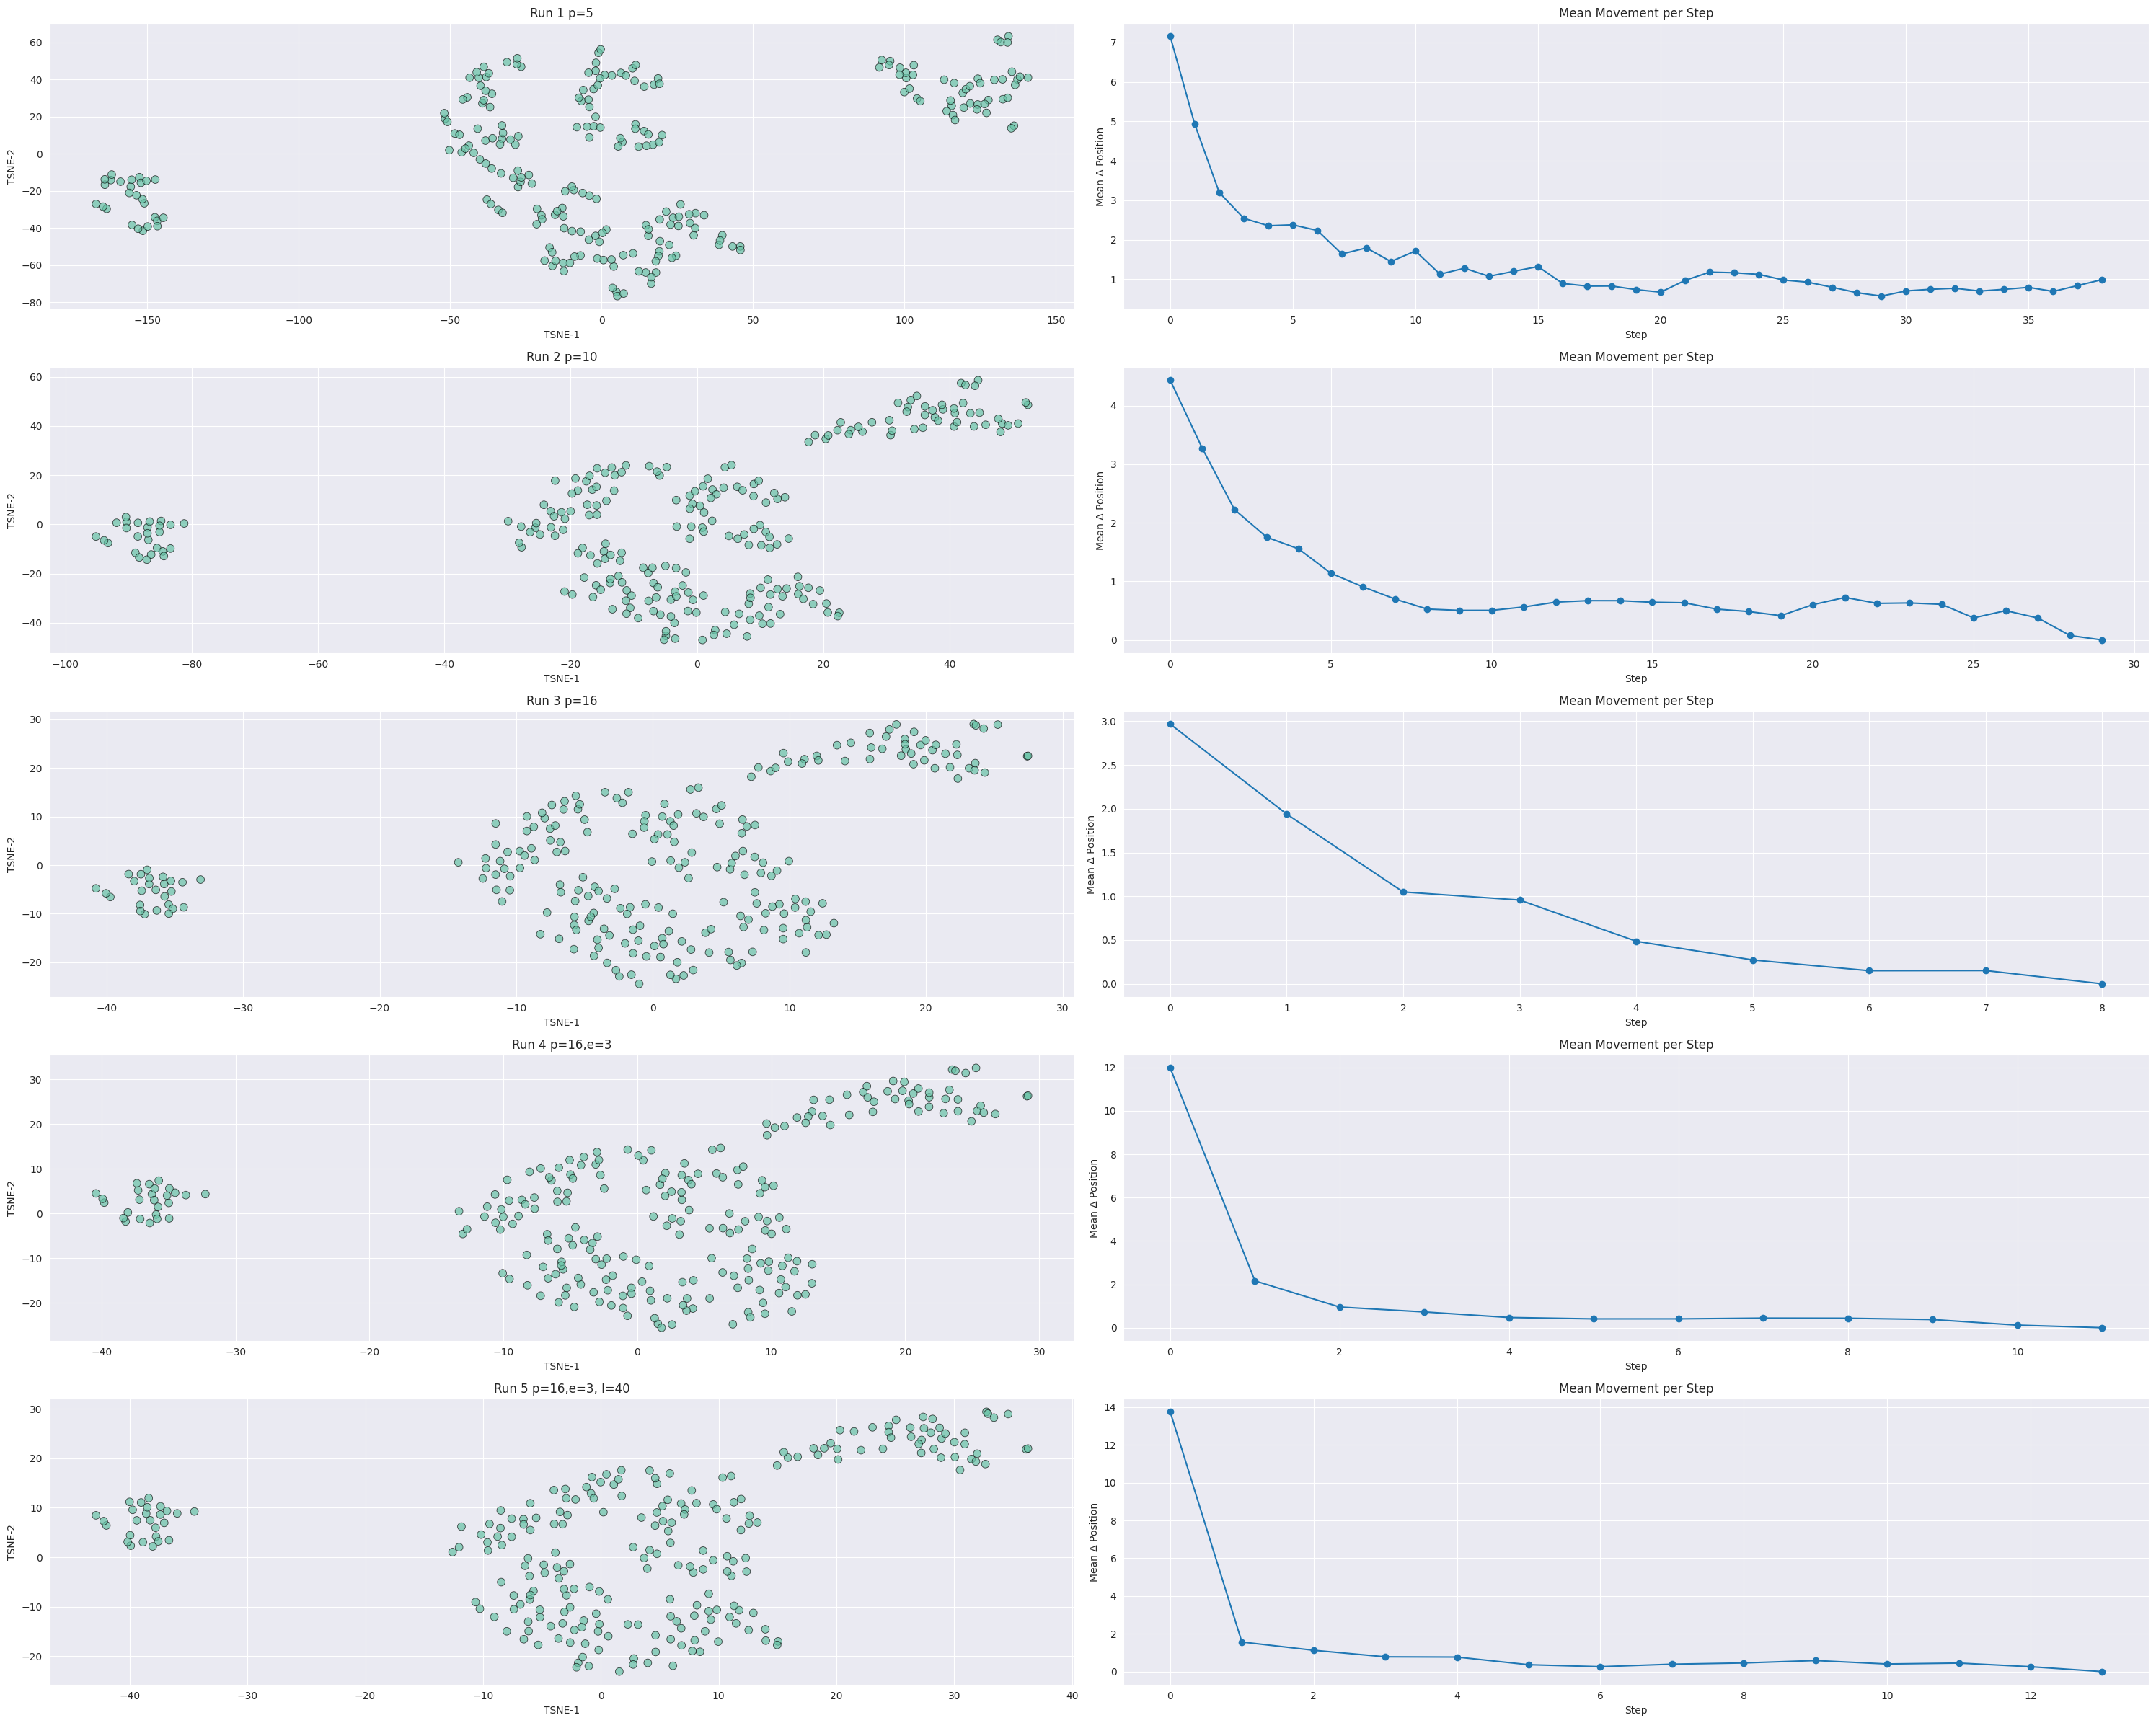

In [65]:
results = [
    (embedding1, movement1),
    (embedding2, movement2),
    (embedding3, movement3),
    (embedding4, movement4),
    (embedding5, movement5),
    # add more if needed
]

plot_tsne_results(results, titles=["Run 1 p=5","Run 2 p=10","Run 3 p=16","Run 4 p=16,e=3","Run 5 p=16,e=3, l=40"])

As we can see there is not much variation. There are 3 distinctive groups in all pictures. The standard setting in run2 leads to vertically squeezed distribution. The result in this respect seems better in run 5.

### Expectation
As mentioned earlier i was not entirely happy with the matches and cut the files into two groups. One which I experienced as quiter. Let's see if we can find this in the data.

In [66]:
labels = [f for f in manifest['theme']]
# 4.  Create your tsne DataFrame
tsne_df = pd.DataFrame({
    "x": embedding5[:, 0],
    "y": embedding5[:, 1],
    "theme": labels,
    "filename": filenames
})

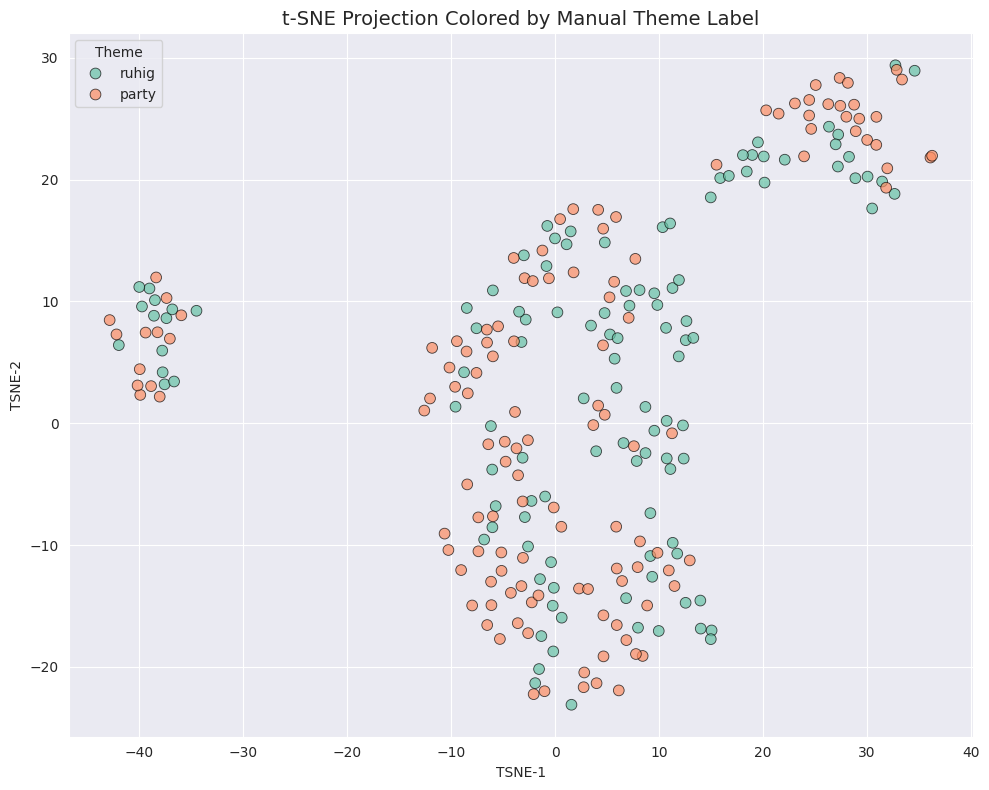

In [67]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x='x', y='y',
    hue='theme',           # <— manual labels from your CSV
    palette='Set2',        # or use your own palette dict
    s=60, edgecolor='k', alpha=0.7
)

plt.title("t-SNE Projection Colored by Manual Theme Label", fontsize=14)
plt.xlabel("TSNE-1"); plt.ylabel("TSNE-2")
plt.legend(title="Theme")
plt.tight_layout()
plt.show()

Overall the data does not fit the perceived feature of "quitness". The only think that is noticeable in the picture is a clustering of green points to left and the buttom of the patch 2 and 3, respectively.

#### Intra- and inter-theme similarity
We can express this in numbers and calculate Intra- and inter-theme similarity. The themes should be distinct and have little variation.

In [68]:
from sklearn.metrics.pairwise import cosine_distances
import itertools

# Group vectors by theme
theme_to_indices = tsne_df.groupby("theme").groups
theme_names = list(theme_to_indices.keys())

# Prepare results
similarity_stats = []

for t1, t2 in itertools.combinations_with_replacement(theme_names, 2):
    i1 = list(theme_to_indices[t1])
    i2 = list(theme_to_indices[t2])

    vec1 = X[i1]
    vec2 = X[i2]

    distances = cosine_distances(vec1, vec2)
    mean_distance = distances.mean()

    similarity_stats.append({
        "theme_1": t1,
        "theme_2": t2,
        "mean_cosine_distance": mean_distance
    })

similarity_df = pd.DataFrame(similarity_stats)
similarity_df.sort_values(by="mean_cosine_distance", inplace=True)
similarity_df


,theme_1,theme_2,mean_cosine_distance
0,party,party,0.040207
2,ruhig,ruhig,0.046004
1,party,ruhig,0.048002


In [69]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, labels, metric='cosine')
print(f"Silhouette Score (cosine): {score:.3f}")


Silhouette Score (cosine): 0.085


This is very close to zero and confirms our visual impression. The manual groups have nothing to do with the automatic selection. This explains why i was not satisfied. Features that i deemed important, are somehow not in the data. Interesting.

Let's study more how the model bevaves with respect to a query.

our query song is Luna - Bombay Bicycle Club.mp3

it should find Kids - MGMT.mp3

whereas in my final playlist which used noise in the generation and manual edits i have Every Breath You Take - The Police.mp3.


In [167]:
def find_index(manifest, search_term):
    matches = manifest[manifest["filename"].str.contains(search_term, case=False)]
    return matches.index[0] if not matches.empty else None

def get_vector(vectors, index):
    return vectors[index].reshape(1, -1)

def compare_query_to_title(query,vectors,manifest, title ):
    target_idx = find_index(manifest, title)
    target_vec = get_vector(vectors, target_idx)
    sim = cosine_similarity(query_vec, target_vec)[0][0]
    print(f"Similarity to {title}: {sim:.3f}")

def most_similar(query_vec, vectors, filenames, exclude_idx=None):
    if exclude_idx is not None:
        vectors = np.delete(vectors, exclude_idx, axis=0)
        filenames = np.delete(filenames, exclude_idx)

    sims = cosine_similarity(query_vec, vectors)[0]
    min_idx = np.argmin(sims)
    min_score = sims[min_idx]
    min_match = filenames_others[min_idx]

    print(f"Weakest match cosine similarity: {min_score:.3f}")
    top_idx = np.argmax(sims)
    return filenames[top_idx], sims[top_idx]


In [157]:
query_idx = find_index(manifest, "Purple Rain - Prince")
query_vec = get_vector(vectors, query_idx)

best_match, score = most_similar(query_vec, vectors, filenames, exclude_idx=query_idx)
print(f"Best match: {best_match} — cosine sim: {score:.3f}")


Weakest match Cosine similarity: 0.825
Best match: /opt/project/data/raw-previews/combined/Mesmerise - Temples.mp3 — cosine sim: 0.999


In [168]:
compare_query_to_title(query_vec,vectors,manifest, "Everybody Wants To Rule The World - Tears For Fears")


Similarity to Everybody Wants To Rule The World - Tears For Fears: 0.998


In [169]:
compare_query_to_title(query_vec,vectors,manifest, "Luna - Bombay Bicycle Club")


Similarity to Luna - Bombay Bicycle Club: 0.995


In [170]:
compare_query_to_title(query_vec,vectors,manifest, "Mr. Brightside - The Killers")


Similarity to Mr. Brightside - The Killers: 0.933


In [171]:
compare_query_to_title(query_vec,vectors,manifest, "Kiss from a Rose - Seal")



Similarity to Kiss from a Rose - Seal: 0.990


My final playlist had this ordering

- Luna - Bombay Bicycle Club.mp3
- Purple Rain - Prince.mp3
- Everybody Wants To Rule The World - Tears For Fears.mp3
- Kiss from a Rose - Seal.mp3

whereas the killers got completly kicked away.


In [189]:
labels = ["none"] * len(filenames)

songs = ["Purple Rain - Prince","Mesmerise - Temples", "Everybody Wants To Rule The World - Tears For Fears","Mr. Brightside - The Killers",]



for i, f in enumerate(filenames):
    for song in songs:
        if song in f:  # match by substring
            labels[i] = song
            print(song)
            break

tsne_df = pd.DataFrame({
    "x": embedding5[:, 0],
    "y": embedding5[:, 1],
    "theme": labels,
    "filename": filenames
})

Purple Rain - Prince
Everybody Wants To Rule The World - Tears For Fears
Mesmerise - Temples
Mr. Brightside - The Killers


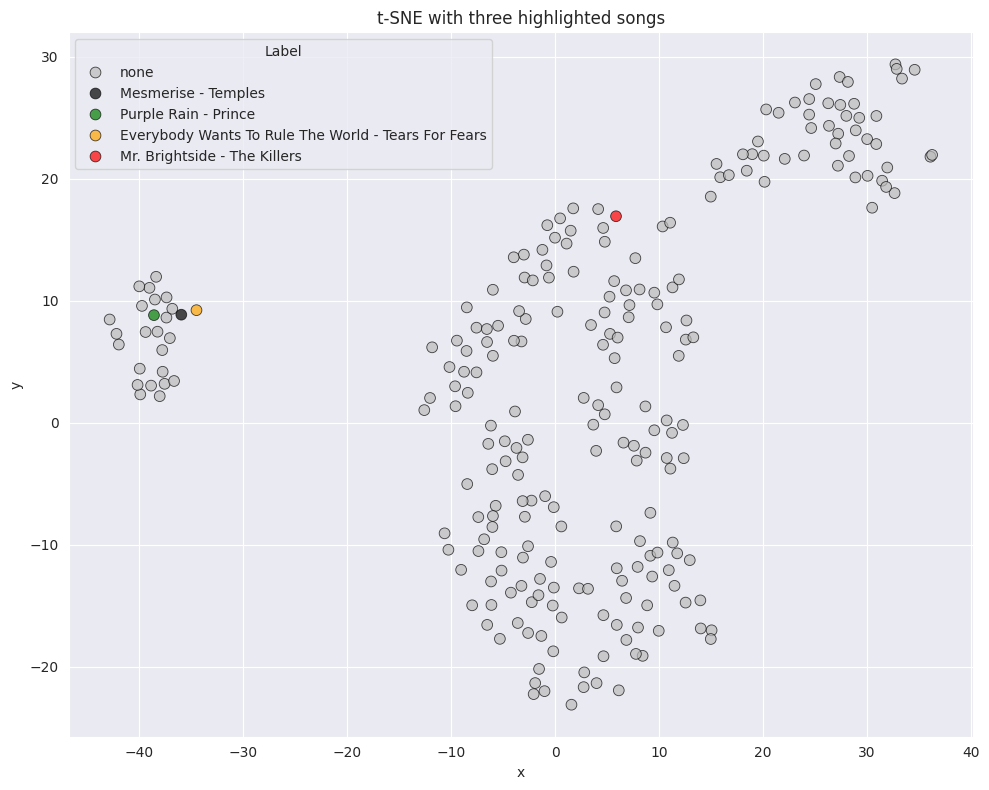

In [191]:

palette = {
    "none":   "#bbbbbb",
    songs[1]:  "black",
    songs[0]:  "green",
    songs[2]: "orange",
    songs[3]: "red",

}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x="x", y="y",
    hue="theme", hue_order=["none", songs[1], songs[0], songs[2], songs[3]],
    palette=palette,
    s=60, edgecolor="k", alpha=0.7
)
plt.legend(title="Label", loc="best")
plt.title("t-SNE with three highlighted songs")
plt.tight_layout()
plt.show()

We can see well in this picture that `Temples - Mesmerise` should have been picked. The nearby match `Everybody Wants To Rule The World - Tears For Fears` only got taken because i interferred with the playlist matching.

In [ ]:
## Integrated gradients
Why did the model prefer Song A over Song B?
We know that the model turns spectrograms into 128-D vectors and ranks candidates using cosine similarity—but that doesn't tell us why one track got a higher score.
To dig deeper, we use Integrated Gradients (IG) to ask:
Which parts of the spectrogram contributed most to the similarity score?
